<a href="https://colab.research.google.com/github/bmurmann/Ngspice-on-Colab/blob/main/notebooks/SKY130_PMOS_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKY130 PMOS debug

# Set up dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

CONDA_PREFIX = os.environ.get('CONDA_PREFIX', None)
if not CONDA_PREFIX:
  !python -m pip install condacolab
  import condacolab
  condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
%%writefile environment.yml
channels:
  - litex-hub
dependencies:
  - open_pdks.sky130a
  - ngspice

Overwriting environment.yml


In [3]:
!mamba env update -n base -f environment.yml

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s
[+] 0.1s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾  litex-hub/linux-64                                            No change
[+] 0.2s
litex-hub/noarch  ⣾  [+] 0.3s
litex-hub/noarch  ⣾  litex-hub/noarch                                              No change


Looking for: ['open_pdks.sky130a', 'ngspice']



  Pinned packages:

  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already installed

Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done
#
# To activate this environment, use
#
#     $ conda activate base
#
# To deactivate an active environment, use
#
#     $ conda deactivate



#Build tweaked BSIM4 model

In [4]:
df=pd.read_csv('https://docs.google.com/spreadsheets/d/' +
            '1Hwd8noFhY4iLRD1ox5WdAPWIZPu_natdPsb85dYDgkc' +
            '/export?gid=0&format=csv')
df

,Param,HVT_PMOS,SVT_PMOS,LVT_PMOS,SVT_PMOS_tweaked,Comments
0,NaN,BAD,VERY BAD,GOOD,NaN,NaN
1,model,xmh:sky130_fd_pr__pfe,xms:sky130_fd_pr__pfe,xml:sky130_fd_pr__pfe,my_pmos_s,NaN
2,capmod,2,2,2,2,NaN
3,diomod,1,1,1,1,NaN
4,rdsmod,0,0,0,0,NaN
...,...,...,...,...,...,...
743,vgsr_max,1.00E+99,1.00E+99,1.00E+99,1.00E+99,NaN
744,vgdr_max,1.00E+99,1.00E+99,1.00E+99,1.00E+99,NaN
745,vgbr_max,1.00E+99,1.00E+99,1.00E+99,1.00E+99,NaN
746,vbsr_max,1.00E+99,1.00E+99,1.00E+99,1.00E+99,NaN


In [5]:
f = open('tweaked_model.txt', 'w')
f.write("*Tweaked SKY130 SVT PMOS model\n")
f.write(".model tweaked_pmos pmos level=54.0 tnom=30.0\n")
for num in range(2, len(df.index)):
   f.write('+' +df.Param[num] +'=' +df.SVT_PMOS_tweaked[num] +'\n')
f.close()

In [6]:
!head tweaked_model.txt

*Tweaked SKY130 SVT PMOS model
.model tweaked_pmos pmos level=54.0 tnom=30.0
+capmod=2
+diomod=1
+rdsmod=0
+trnqsmod=0
+acnqsmod=0
+mobmod=0
+rbodymod=1
+rgatemod=0


In [7]:
!tail tweaked_model.txt

+vgd_max=1.00E+99
+vgb_max=1.00E+99
+vds_max=1.00E+99
+vbs_max=1.00E+99
+vbd_max=1.00E+99
+vgsr_max=1.00E+99
+vgdr_max=1.00E+99
+vgbr_max=1.00E+99
+vbsr_max=1.00E+99
+vbdr_max=1.00E+99


# Simulation

In [8]:
%%writefile .spiceinit
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
set ngbehavior=hsa
* "nomodcheck" speeds up loading time
set ng_nomodcheck

Writing .spiceinit


In [9]:
%%writefile netlist.spice
* PMOS VGS sweep
.lib "/usr/local/share/pdk/sky130A/libs.tech/ngspice/sky130.lib.spice" tt
XMS vdp vgp 0 vbp sky130_fd_pr__pfet_01v8 L=0.15 W=2 nf=1 mult=1 m=1
+ ad='int((nf+1)/2) * W/nf * 0.29' as='int((nf+2)/2) * W/nf * 0.29'
+ pd='2*int((nf+1)/2) * (W/nf + 0.29)' ps='2*int((nf+2)/2) * (W/nf + 0.29)' nrd='0.29 / W' nrs='0.29 / W'
+ sa=0 sb=0 sd=0

.inc "tweaked_model.txt"
MS_tweak vdp vgp 0 vbp tweaked_pmos L=0.15 W=2
+as=5.8e-1 ad=5.8e-1 ps=4.58 pd=4.58 nrd=0.145 nrs=0.145

vsdp     0  vdp        dc 0.9
vsgp     0  vgp        dc 0.9
vsbp     0  vbp        dc 0
.end

.control
set wr_singlescale
save all
+ @m.XMS.msky130_fd_pr__pfet_01v8[gm] @m.XMS.msky130_fd_pr__pfet_01v8[id]
+ @MS_tweak[gm] @MS_tweak[id]
op
show
showmod m.XMS.msky130_fd_pr__pfet_01v8 MS_tweak
dc vsgp -0.5 1.8 0.01
wrdata output.txt
+ @m.XMS.msky130_fd_pr__pfet_01v8[gm] @m.XMS.msky130_fd_pr__pfet_01v8[id]
+ @MS_tweak[gm] @MS_tweak[id]
.endc

Writing netlist.spice


In [10]:
!ngspice -b netlist.spice


Note: Compatibility modes selected: hs a



Circuit: * pmos vgs sweep

option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

 Reference value :  0.00000e+00
No. of Data Rows : 1
 BSIM4v5: Berkeley Short Channel IGFET Model-4
     device              ms_tweak m.xms.msky130_fd_pr__
      model          tweaked_pmos xms:sky130_fd_pr__pfe
          l               1.5e-07               1.5e-07
          w                 2e-06                 2e-06
          m                     1                     1
         nf                     1                     1
         sa                     0                     0
         sb                     0                     0
         sd                     0                     0
        sca                     0                     0
        scb                     0                     0
        scc                     0                     0
         sc                  

In [11]:
df = pd.read_csv("output.txt", delim_whitespace=True, header=None)
df.columns = ["vsg", "gm_S", "id_S", "gm_S_tweak", "id_S_tweak"]
df['gm_id_S'] = df.gm_S/df.id_S
df['gm_id_S_tweak'] = df.gm_S_tweak/df.id_S_tweak
df

,vsg,gm_S,id_S,gm_S_tweak,id_S_tweak,gm_id_S,gm_id_S_tweak
0,-0.50,2.586685e-15,9.725858e-17,6.546519e-17,2.461143e-18,26.595953,26.599504
1,-0.49,3.374672e-15,1.268910e-16,8.541422e-17,3.211124e-18,26.595049,26.599480
2,-0.48,4.402641e-15,1.655501e-16,1.114422e-16,4.189643e-18,26.594015,26.599452
3,-0.47,5.743649e-15,2.159848e-16,1.454016e-16,5.466344e-18,26.592835,26.599420
4,-0.46,7.492974e-15,2.817809e-16,1.897091e-16,7.132088e-18,26.591487,26.599384
...,...,...,...,...,...,...,...
226,1.76,3.828918e-04,3.009412e-04,3.773411e-04,2.944305e-04,1.272314,1.281596
227,1.77,3.812079e-04,3.047614e-04,3.757259e-04,2.981956e-04,1.250841,1.259998
228,1.78,3.794326e-04,3.085643e-04,3.740199e-04,3.019440e-04,1.229671,1.238706
229,1.79,3.775670e-04,3.123490e-04,3.722242e-04,3.056749e-04,1.208799,1.217713


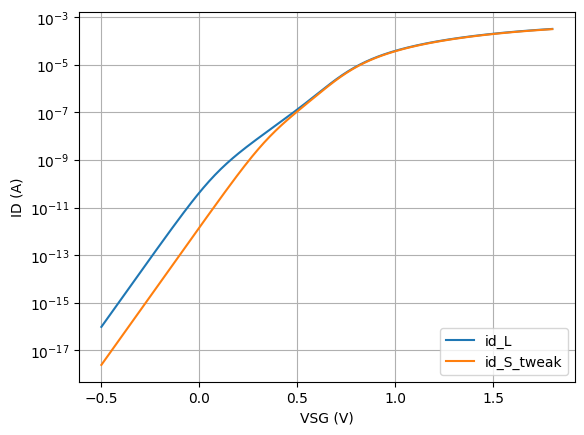

In [12]:
plt.semilogy(df.vsg, df.id_S, label="id_L")
plt.semilogy(df.vsg, df.id_S_tweak, label="id_S_tweak")
plt.xlabel("VSG (V)")
plt.ylabel("ID (A)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

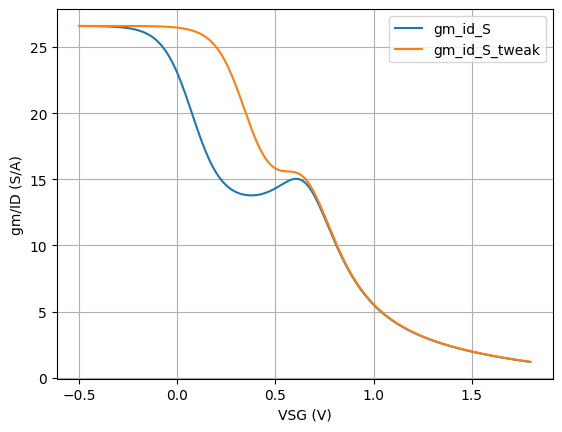

In [13]:
plt.plot(df.vsg, df.gm_id_S, label="gm_id_S")
plt.plot(df.vsg, df.gm_id_S_tweak, label="gm_id_S_tweak")
plt.xlabel("VSG (V)")
plt.ylabel("gm/ID (S/A)")
plt.legend(loc="upper right")
plt.grid()
plt.show()